Authors: Ata Akbari Asanjan<br>
&emsp;&emsp;&emsp;&emsp;Lucas Brady (lucas.t.brady@nasa.gov)<br>
&emsp;&emsp;&emsp;&emsp;Aaron P. Lott (aaron.lott@nasa.gov)

Copyright © 2023, United States Government, as represented by the Administrator
of the National Aeronautics and Space Administration. All rights reserved.

The *PySA*, a powerful tool for solving optimization problems is licensed under
the Apache License, Version 2.0 (the "License"); you may not use this file
except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0. 

Unless required by applicable law or agreed to in writing, software distributed
under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR
CONDITIONS OF ANY KIND, either express or implied. See the License for the
specific language governing permissions and limitations under the License.

# RBM trained using Ising solvers

In this example, we go over two Restricted Boltzmann Machines (RBMs) that are trained via:

1. Persistent Contrastive Divergence
2. PySA

## Restricted Boltzmann Machines (RBM)

Restricted Boltzmann Machines (RBMs) are a type of generative probabilistic model that can learn to extract features from input data. They are used for various tasks such as dimensionality reduction, collaborative filtering, and unsupervised deep learning.

### Components of RBM

- Visible Units: Represent the input data, and are also called visible nodes or visible neurons.
- Hidden Units: Represent the extracted features, and are also called hidden nodes or hidden neurons.
- Weights: Represent the connection strengths between visible and hidden units.
- Bias Terms: Represent the biases of visible and hidden units.
- Energy Function
The energy function of an RBM is a measure of how likely a given configuration of visible and hidden units is. The energy function is defined as:

$$
E(v, h) = -∑(v * bv) - ∑(h * bh) - ∑(v * W * h)
$$

where v is the vector of visible units, h is the vector of hidden units, bv is the vector of visible biases, bh is the vector of hidden biases, and W is the weight matrix.

- Free Energy
The free energy of an RBM is a scalar value that represents the minimum energy required to reconstruct the visible data given the hidden data. The free energy is defined as:

$$
F(v) = -∑(v * bv) - ∑(log(1 + exp(W * v + bh)))
$$

### Training RBM
The goal of training an RBM is to learn the weights and biases that minimize the negative log likelihood (NLL) of the data. To train an RBM, the most commonly used algorithm is Contrastive Divergence (CD). In CD, the negative phase is used to approximate the gradient of the NLL with respect to the weights and biases.

To calculate the NLL, the positive phase computes the energy of the input data and the negative phase computes the energy of the reconstructed data. The difference between these two energies is the NLL. The weights and biases are updated in the direction of the negative gradient of the NLL using gradient descent or a related optimization algorithm.

In [1]:
import torch
import numpy as np
from tqdm import tqdm
import torchvision as tv
import matplotlib.pyplot as plt

from rbm import *
from rbm_pysa import *

### Dummy Data

For this example, we defined two datasets:
1. __Bars & Stripes__

    The "Bars and Stripes" dataset is a collection of binary images that consist of either vertical stripes or horizontal bars. Each image is a fixed size, typically small (e.g. 8x8 pixels), and consists of black and white pixels. The dataset is often used for testing and demonstrating the capabilities of computer vision algorithms, as well as for benchmarking machine learning models such as Restricted Boltzmann Machines (RBMs). The images in the dataset are typically generated algorithmically, rather than being sourced from real-world sources. The simplicity of the Bars and Stripes images makes them well-suited for testing algorithms that can distinguish between patterns of different orientations, and for developing models that can recognize basic visual features.
2. __MNIST images__
    
    Handwritten digits of numbers 0 to 9

In [2]:
def generate_bars_and_stripes(n, num_samples=1000):
    """
    Generates a bars and stripes dataset.

    Parameters
     n (int): The size of each image, in pixels.
        num_samples (int, optional): The number of images to generate. Defaults to 1000.

    Returns:
        torch.Tensor: The generated dataset, represented as a tensor of shape (num_samples, n * n).
    """
    data = np.zeros((num_samples, n * n))
    for i in range(num_samples):
        values = np.dot(np.random.randint(low=0, high=2,
                                              size=(n, 1)),
                          np.ones((1, n)))
        if np.random.random() > 0.5:
            values = values.T
        data[i, :] = values.reshape(n * n)
    return torch.tensor(data).float()

### Hyper-parameters

In [3]:
lr = 0.01                             # Learning rate
steps = 1                             # Number of  (known as k in the literature)
epochs = 10                           # Number of epochs for training
state_size = 100                      # Size of persistent state
dataset = "mnist"                     # Name of the dataset (two option: (1) mnist and (2) bars&stripes


if dataset == "mnist":
    batch_size = 16
    size = [28, 28]
    visible_dim = 784
    hidden_dim = 128
    # Define the transformation for data
    transform = tv.transforms.Compose([tv.transforms.ToTensor()])
    # Load dataset
    trainset = tv.datasets.MNIST(root="./MNIST", train=True, download=True, transform=transform)
    # Let's keep only the first `batch_size` * 10 number of data
    trainset.data = trainset.data[:batch_size*10]
    # Define the data loader
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=2)
elif dataset == "bars&stripes":
    batch_size = 16
    size = [3, 3]
    visible_dim = 9
    hidden_dim = 6
    # Define the data
    data = generate_bars_and_stripes(3, 10000)
    # Wrap tensor in TensorDataset
    trainset = torch.utils.data.TensorDataset(data, torch.zeros(data.shape[0],))
    # Define the data loader
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



## Train RBM via Persistent Contrastive Divergence

Persistent Contrastive Divergence (PCD) is a training algorithm used for Restricted Boltzmann Machines (RBMs). It is an improvement over the standard Contrastive Divergence (CD) algorithm and offers faster convergence in RBM training. The main idea behind PCD is to maintain a persistent chain of hidden units during the training process. This persistent chain is used to estimate the gradient in both the positive and negative phases of the training, instead of randomly sampling hidden units in each iteration like in CD. By using the same hidden units for both phases, PCD helps to stabilize the gradient estimate and avoid oscillations during training, resulting in more reliable and faster convergence compared to CD. PCD is widely used for training RBMs in various applications and has become a popular choice for training these models.

In [4]:
# Define the model
rbm_pcd = RBM(visible_dim=visible_dim, hidden_dim=hidden_dim, state_size=state_size, steps=steps)
# Define the optimizer
optimizer = torch.optim.Adam(rbm_pcd.parameters(), lr=lr)

loss_track = []
for epoch in range(1, epochs+1):
    loss_ = []
    pbar = tqdm(trainloader, unit="batch")
    for x, _ in pbar:
        pbar.set_description(f"{epoch}/{epochs}")
        if dataset == "mnist":
            x = (x.view(x.shape[0], -1) > 0.4).float().to(rbm_pcd.device)
        elif dataset == "bars&stripes":
            x = x.float().to(rbm_pcd.device)
        # Update persistent states of RBM
        rbm_pcd.update_state()
        # Calculate the loss (i.e. negative log likelihood)
        loss = -rbm_pcd.log_prob(x).sum()
        # Optimize the parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Store and report loss
        loss_.append(loss.item())
        pbar.set_postfix(loss=loss.item())
    loss_track.append(np.mean(loss_))

10/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 65.49batch/s, loss=2.72e+3]


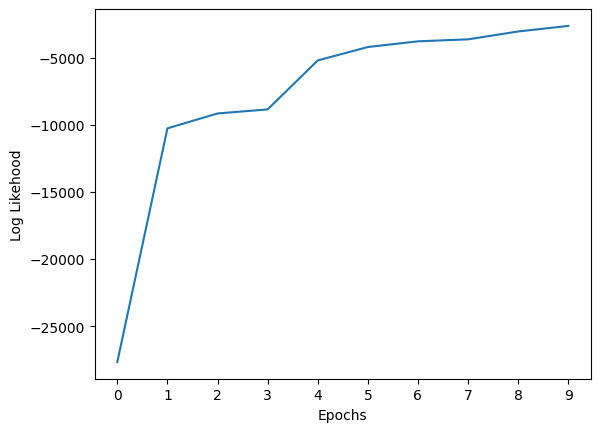

In [5]:
# Plot the progress of log likelihood vs. epochs
plt.plot(np.array(loss_track) * -1)
plt.ylabel("Log Likehood")
plt.xticks(range(epochs))
plt.xlabel("Epochs");

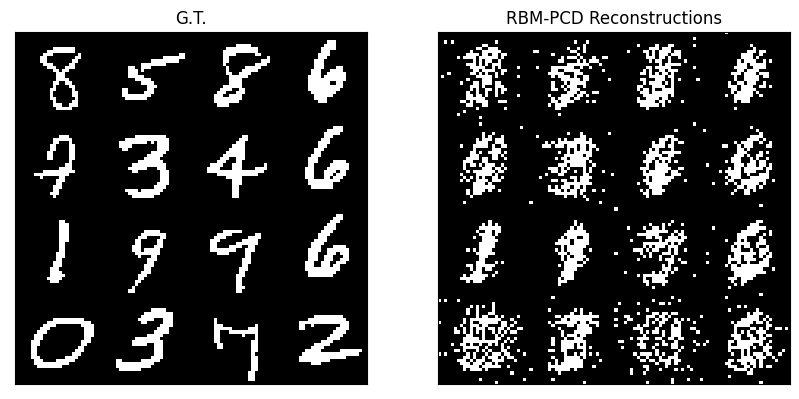

In [6]:
# Reconstruct the samples
xg = rbm_pcd(x).detach().cpu().view(-1, *size)
# Reshape the G.T. data
xx = x.cpu().view(-1, *size)

# Stack the images in a grid using make_grid
gt_grid = tv.utils.make_grid(xx[:, None], padding=0, pad_value=1, nrow=int(np.sqrt(len(x))))
pred_grid = tv.utils.make_grid(xg[:, None], padding=0, pad_value=1, nrow=int(np.sqrt(len(xg))))

# Plot
plt.figure(figsize=(10, 20))
plt.subplot(1, 2, 1)
plt.imshow(gt_grid[0], cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title("G.T.")

plt.subplot(1, 2, 2)
plt.imshow(pred_grid[0], cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title("RBM-PCD Reconstructions");

# Train RBM with PySA

In [7]:
# Define the model
# # You can change the parallel to `True` to use parallel processing (speed up depends of the system arch.)
# # You can also look at multiple parameters belonging to PySA such as `min_temp` and `max_temp`. For more refer to `rbm_pysa.py`.
rbm_pysa = RBM_PySA(visible_dim=visible_dim, hidden_dim=hidden_dim, state_size=state_size, steps=steps, parallel=False, min_temp=1, max_temp=1)
# Define the optimizer
optimizer = torch.optim.Adam(rbm_pysa.parameters(), lr=lr)

loss_track = []
for epoch in range(1, epochs+1):
    loss_ = []
    pbar = tqdm(trainloader, unit="batch")
    for x, _ in pbar:
        pbar.set_description(f"{epoch}/{epochs}")
        if dataset == "mnist":
            x = (x.view(x.shape[0], -1) > 0.4).float().to(rbm_pysa.device)
        elif dataset == "bars&stripes":
            x = x.float().to(rbm_pysa.device)
        
        # Update persistent states using PySA
        rbm_pysa.update_states_with_pysa()
        # Calculate the loss (i.e. negative log likelihood)
        loss = -rbm_pysa.log_prob(x).sum()
        # Optimize the parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Store and report loss
        loss_.append(loss.item())
        pbar.set_postfix(loss=loss.item())
    loss_track.append(np.mean(loss_))

10/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.56batch/s, loss=3.69e+3]


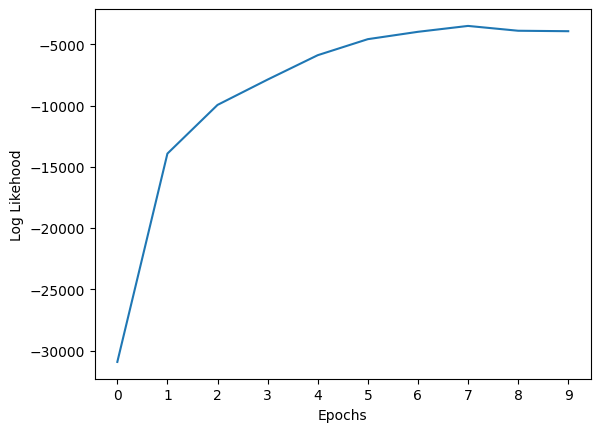

In [8]:
# Plot the progress of log likelihood vs. epochs
plt.plot(np.array(loss_track) * -1)
plt.ylabel("Log Likehood")
plt.xticks(range(epochs))
plt.xlabel("Epochs");

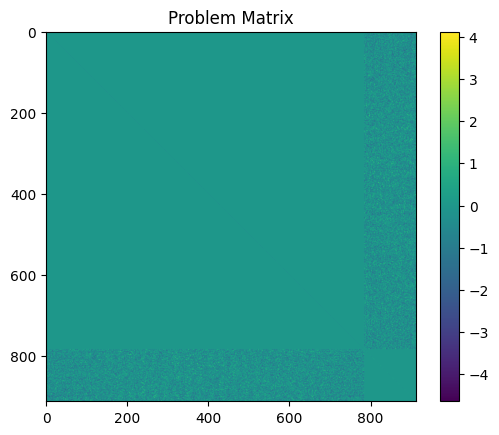

In [9]:
# Plot the Problem matrix
plt.imshow(rbm_pysa.problem.detach())
plt.colorbar()
plt.title("Problem Matrix");

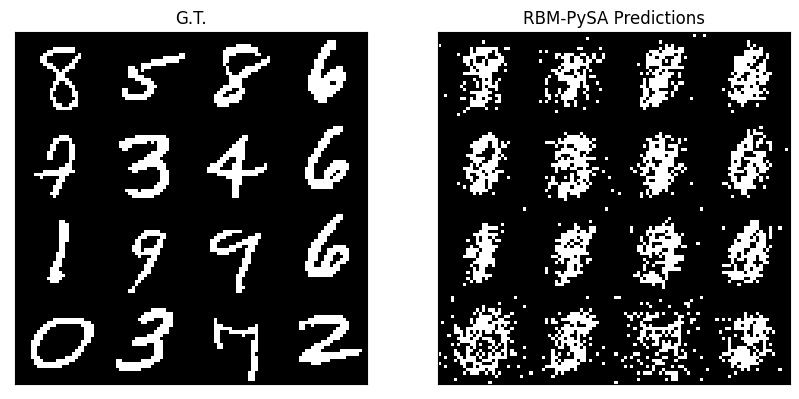

In [10]:
# Reconstruct the samples
xg = rbm_pysa(x).detach().cpu().view(-1, *size)
# Reshape the G.T. data
xx = x.cpu().view(-1, *size)

# Stack the images in a grid using make_grid
gt_grid = tv.utils.make_grid(xx[:, None], padding=0, pad_value=1, nrow=int(np.sqrt(len(x))))
pred_grid = tv.utils.make_grid(xg[:, None], padding=0, pad_value=1, nrow=int(np.sqrt(len(xg))))

# Plot
plt.figure(figsize=(10, 20))
plt.subplot(1, 2, 1)
plt.imshow(gt_grid[0], cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title("G.T.")

plt.subplot(1, 2, 2)
plt.imshow(pred_grid[0], cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title("RBM-PySA Predictions");